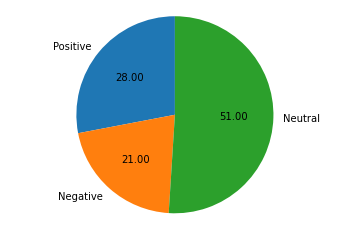

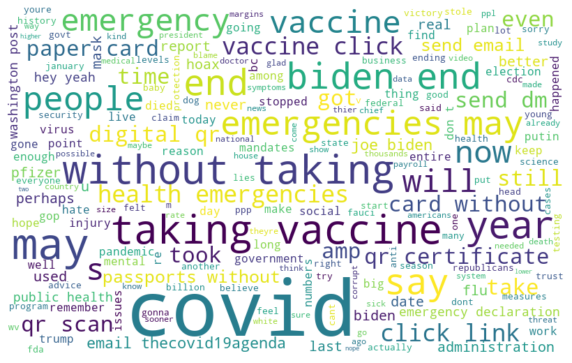

OSError: Cannot save file into a non-existent directory: 'Projects\Twitternproject-python\tweets'

In [9]:

import tweepy
import pandas as pd
import numpy as np
import re
from better_profanity import profanity
from textblob import TextBlob 
from pandasql import sqldf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time
import calendar

client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAGF6lAEAAAAAKzMMG6wnZxn7NXSxjENcTRCv9uM%3DZ1Oiffr2Ql1eNEUCHR5eCMOzhyPC1KWJd4zPNdi0KCCl52TnA5')

initq = 'covid'
query = initq + ' -is:retweet lang:en'

tweets = client.search_recent_tweets(query=query, tweet_fields=['author_id', 'created_at'], max_results=100)

#for tweet in tweets.data:
#    print(tweet.text)
    
list1 = [[tweet.text] for tweet in tweets.data]
#print(list1)

# Convert the list into a dataframe

df = pd.DataFrame(data=list1, columns=['tweets'])
# Convert only the tweets into a list

tweet_list = df.tweets.to_list()

def clean_tweet(tweet):
    if type(tweet) == np.cfloat:
        return ""
    r = tweet.lower()
    r = profanity.censor(r)
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = re.sub("\n"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

cleaned = [clean_tweet(tw) for tw in tweet_list]

#print(tweet_list)
#print('#######################')
#print(cleaned)

# Define the sentiment objects using TextBlob
sentiment_objects = [TextBlob(tweet) for tweet in cleaned]

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "cleanedtweet"])    

#tweets_analysis = pd.concat([sentiment_df,df],axis=1)
tweets_analysis = sentiment_df

s=sqldf(
    """select 
        count(case when polarity > 0 then 'positive' end ) as pos
        ,count(case when polarity < 0 then 'negative' end ) as neg
        ,count(case when polarity = 0 then 'neutral' end  ) as neu        
        from tweets_analysis
        """

        )


pieLabels=["Positive","Negative","Neutral"]

populationShare=[s.pos[0],s.neg[0],s.neu[0]]

figureObject, axesObject = plt.subplots()

axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)

axesObject.axis('equal')

plt.show()

# Create a Wordcloud from the tweets

all_words = ' '.join([text for text in cleaned])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

tweets_analysis.to_csv('Projects\\Twitternproject-python\\tweets\\' + initq + '_' + str(calendar.timegm(time.gmtime())) + '.csv','|')


